### Bibliotecas Utilizadas

In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel

- Carregando o dataset e transformando-o em dataframe via lib pandas

In [16]:
df_breast = pd.read_csv('Breast_cancer_dataset.csv', sep=',', index_col=False)
df_breast.drop(columns=['Unnamed: 32'], inplace=True)
df_breast.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Análise do dataset: 
- Somente a coluna diagnosis é composta por valores categóricos discretos
- As demais colunas representam variáveis númericas contínuas

### 1)

- Inicialmente vamos usar 5-fold stratified cross-validation, que tem como ideia garantir a proporção entre as classes "M/F" em cada um dos folds
- Shuffling, basicamente vai promover o embaralhamento pré divisão, assim como em jogos de carta, por exemplo 

Vamos comparar a performace entre kNN com k=5 e Naive Bayes levando em conta Gaussian assumption, para isso: 
- Separamos as features do outcome
- Codificamos o target, no qual invés de ser uma variável categórica discreta, vai passar a ser uma binária, sendo M -> 1 e F -> 0, isso vai facilitar o treinamento dos modelos 

In [17]:
#separando outcome e features, e id não é uma informação relevante, por isso excluimos
X = df_breast.drop(columns=['id', 'diagnosis'])
y = df_breast['diagnosis']

#codificando o target (M -> 1 e F -> 0)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#### a)

Primeiro vamos computar as acurácias de cada um dos modelos propostos, e assim definimos uma Pipeline a ser seguida:

1) Normalizamos os dados, no qual pelo fato do kNN ser sensível a escala usamos o StandardScaler

2) Aplicamos StratifiedKFold com shuffle 

3) Treinamos e avaliamos cada um dos modelos

In [ ]:
#cross-validation estratificada (com shuffle) k=5
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#pipelines para kNN e Naive Bayes
pipeline_knn = Pipeline([
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

pipeline_nb = Pipeline([
    ('nb', GaussianNB())
])

#avaliação dos modelos
scores_knn = cross_val_score(pipeline_knn, X, y_encoded, cv=cv, scoring='accuracy')
scores_nb = cross_val_score(pipeline_nb, X, y_encoded, cv=cv, scoring='accuracy')

#printar os results
print("=== kNN (k=5) ===")
print(f"Acurácias: {scores_knn}")
print(f"Média: {scores_knn.mean():.4f} | Desvio padrão: {scores_knn.std():.4f}\n")

print("=== Naive Bayes Gaussiano ===")
print(f"Acurácias: {scores_nb}")
print(f"Média: {scores_nb.mean():.4f} | Desvio padrão: {scores_nb.std():.4f}")

#estabilidade
if scores_knn.std() < scores_nb.std():
    print("\nO kNN é mais estável (menor variação entre folds).")
else:
    print("\nO Naive Bayes é mais estável (menor variação entre folds).")

=== kNN (k=5) ===
Acurácias: [0.92982456 0.90350877 0.92982456 0.95614035 0.95575221]
Média: 0.9350 | Desvio padrão: 0.0196

=== Naive Bayes Gaussiano ===
Acurácias: [0.96491228 0.90350877 0.92982456 0.92982456 0.96460177]
Média: 0.9385 | Desvio padrão: 0.0235

O kNN é mais estável (menor variação entre folds).


- Conseguimos observar que o kNN é o mais estável, já que o desvio padrão dele é menor 0.0196 < 0.0235 do que o de Naive Bayes, no qual basicamente o desvio padrão é uma das principais para observarmos o grau de dispersão ou variação de um conjunto de dados, em que quanto menor é esta, menor foi a variação, consequentemente mais estável é este modelo 

#### b)

- Basicamente a ideia aqui é treinar novamente o modelo kNN com k=5, mas realizando um pré-processamento usando Min-Max scaler
- Em que o Min-Max transforma os dados para intervalos de [0,1], em que neste dataset várias variáveis já seguem essa distribuição, muitas ainda não
- A ideia fazendo isso é que o kNN possa usar distâncias euclidianas entre pontos, em que quando esse processo não era feito as features que tinham maior valor "dominavam" e assim "contribuiam" mais, agora usando o min-max com essa normalização a ideia é que as features contribuam de forma mais equilibrada
- Gaussian não vai sofrer muito impacto quanto isso pelo fato de trabalhar com probabilidades normalizadas da distribuição gaussiana, em que basicamente isso irá mudar somente a escala, mas a distribuição segue a tendência de se manter a mesma, então as probabilidades devem se manter as mesmas ou muito similiares

In [19]:
pipeline_knn_minmax = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

scores_knn_minmax = cross_val_score(pipeline_knn_minmax, X, y_encoded, cv=cv, scoring='accuracy')

pipeline_nb = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('nb', GaussianNB())
])
scores_nb = cross_val_score(pipeline_nb, X, y_encoded, cv=cv, scoring='accuracy')

print("=== kNN (k=5) com MinMaxScaler ===")
print(f"Acurácias: {scores_knn_minmax}")
print(f"Média: {scores_knn_minmax.mean():.4f} | Desvio padrão: {scores_knn_minmax.std():.4f}\n")

print("\nComparação com kNN sem escalonamento:")
print(f"Melhoria absoluta: {(scores_knn_minmax.mean() - scores_knn.mean()):.4f}")
print(f"Melhoria percentual: {((scores_knn_minmax.mean() - scores_knn.mean()) / scores_knn.mean() * 100):.2f}%")

print("\nComparação de estabilidade:")
print(f"Desvio padrão (sem scaler): {scores_knn.std():.4f}")
print(f"Desvio padrão (com scaler): {scores_knn_minmax.std():.4f}")
print(f"Redução na variância: {(scores_knn.std() - scores_knn_minmax.std()):.4f}")

print("\n \n=== Naive Bayes Gaussiano (comparação) ===")
print(f"Acurácias: {scores_nb}")
print(f"Média: {scores_nb.mean():.4f} | Desvio padrão: {scores_nb.std():.4f}\n")

=== kNN (k=5) com MinMaxScaler ===
Acurácias: [0.98245614 0.95614035 0.92982456 0.98245614 0.96460177]
Média: 0.9631 | Desvio padrão: 0.0195


Comparação com kNN sem escalonamento:
Melhoria absoluta: 0.0281
Melhoria percentual: 3.00%

Comparação de estabilidade:
Desvio padrão (sem scaler): 0.0196
Desvio padrão (com scaler): 0.0195
Redução na variância: 0.0001

 
=== Naive Bayes Gaussiano (comparação) ===
Acurácias: [0.95614035 0.9122807  0.92982456 0.90350877 0.94690265]
Média: 0.9297 | Desvio padrão: 0.0199



#### c)

- Por último vamos verificar estatisticamente a comparação entre kNN e Gaussian 
- Assim aplicamos o t-test do scipy, e construimos duas hipóteses(nula e alternativa): 

1) ${H_0}$ : ${u_{knn}} = {u_{nvb}}$ -> nula, que a diferença estatísca entre kNN e Gaussian Navie Bayes não é significativa
2) ${H_1}$ : ${u_{knn}} > {u_{nvb}}$ -> alterantiva, que o kNN é estatiscamente superior a Gaussian Navie Bayes

In [20]:
t_stat, p_value = ttest_rel(scores_knn_minmax, scores_nb)
print("=== Teste t pareado ===")
print(f"T-statistic: {t_stat:.4f} | p-value: {p_value:.4f}")

if p_value < 0.05 and scores_knn_minmax.mean() > scores_nb.mean():
    print("Resultado: o kNN com MinMaxScaler é estatisticamente superior ao Naive Bayes (p < 0.05).")
else:
    print("Resultado: não há evidência estatística de superioridade (p >= 0.05).")

=== Teste t pareado ===
T-statistic: 2.4881 | p-value: 0.0676
Resultado: não há evidência estatística de superioridade (p >= 0.05).


- Basicamente aplicamos o t-test com as acurácias médias de cada fold, e assim as comparamos(kNN x Naive Bayes)
- O p-value > 0.05, neste caso p=0.0676, indica que a diferença entre os modelos é estatiscamente significante ao nível de confiança de 93% aproximadamente
- Portanto rejeitamos ${H_1}$ e aceitamos ${H_0}$, de que a diferença estatística entre kNN e Naive Bayes não pe estatiscamente significativa, apesar da diferença entre as acurácias 0.9631(kNN) x 0.9297(Gaussian Naive Bayes)
- Apesar disso, o kNN é fortemente dependente da escala das variáveis, pois utiliza normalmente distâncias euclidianas, em que ao normaliza-las a tendência é que o poder discriminativo do modelo melhore
- E o modelo Naive Bayes Gaussiano é um modelo probabilístico paramétrico, baseado que cada feature segue a distribuição normal independente, em que normalizações como Min-Max não tendem a alterar o poder discrimininativo deste modelo

### 2)

#### a)

- Basicamente vamos dividir o dataset em treino/teste (70/30), e treinar kNN com diferentes k's k = {1,5,10,15,20,25}
- Além disso, vamos testar com dois modelos diferentes de ponderação: 

1) Uniforme: todos os vizinhos tem peso igual
2) Não-uniforme(Distância): vizinhos mais próximos têm mais peso

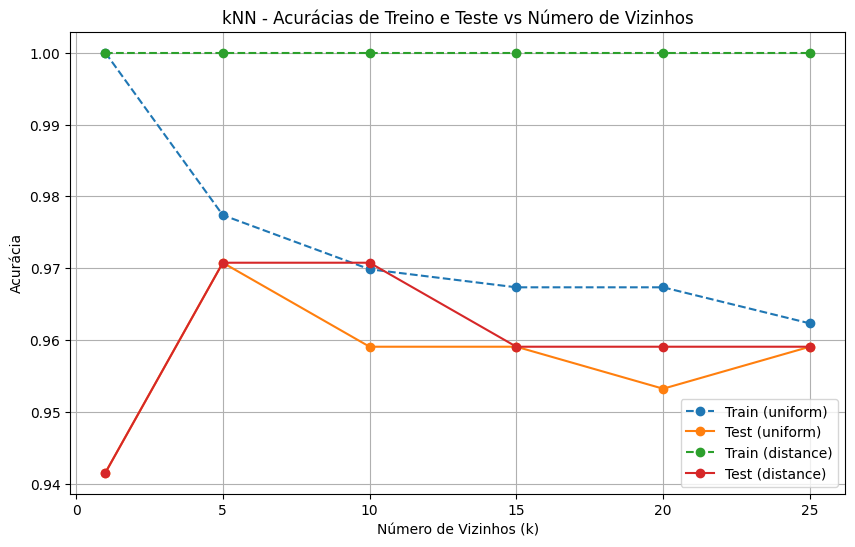


=== UNIFORM weights ===
k= 1 | Treino=1.000 | Teste=0.942
k= 5 | Treino=0.977 | Teste=0.971
k=10 | Treino=0.970 | Teste=0.959
k=15 | Treino=0.967 | Teste=0.959
k=20 | Treino=0.967 | Teste=0.953
k=25 | Treino=0.962 | Teste=0.959

=== DISTANCE weights ===
k= 1 | Treino=1.000 | Teste=0.942
k= 5 | Treino=1.000 | Teste=0.971
k=10 | Treino=1.000 | Teste=0.971
k=15 | Treino=1.000 | Teste=0.959
k=20 | Treino=1.000 | Teste=0.959
k=25 | Treino=1.000 | Teste=0.959


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

#testando diferentes k's e modos de ponderação
k_values = [1, 5, 10, 15, 20, 25]
weight_modes = ['uniform', 'distance']

results = {w: {'train': [], 'test': []} for w in weight_modes}

for w in weight_modes:
    for k in k_values:
        #pipeline com MinMaxScaler e kNN
        model = Pipeline([
            ('scaler', MinMaxScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=k, weights=w))
        ])
        
        #treino e validação
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        #cal das acurácias
        acc_train = accuracy_score(y_train, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)
        
        results[w]['train'].append(acc_train)
        results[w]['test'].append(acc_test)

#plot do gráfico
plt.figure(figsize=(10, 6))
for w in weight_modes:
    plt.plot(k_values, results[w]['train'], '--o', label=f'Train ({w})')
    plt.plot(k_values, results[w]['test'], '-o', label=f'Test ({w})')

plt.title("kNN - Acurácias de Treino e Teste vs Número de Vizinhos")
plt.xlabel("Número de Vizinhos (k)")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.show()

#somente printando os resultados numéricos
for w in weight_modes:
    print(f"\n=== {w.upper()} weights ===")
    for k, train_acc, test_acc in zip(k_values, results[w]['train'], results[w]['test']):
        print(f"k={k:2d} | Treino={train_acc:.3f} | Teste={test_acc:.3f}")

#### b)

- De modo geral, o que pode se observar mais é que o parâmetro k vai controlar o nível de suavização do kNN, no qual: 
- k pequeno -> modelo muito sensível aos dados(baixo viés, alta variância)
- k grande -> modelo mais estável e generalizado(alto viés, baixa variância)

Podemos agrupar os k em três classes de acordo com os resultados obtidos: 

1) k=1 -> overfitado, dados de teste não tem bom desempenho
2) k={5,10,15} -> boa generalização e menor variância 
3) k={20,25} -> tendência ao underfiting, perdendo detalhes das estruturas dos dados, pior discriminação entre classes próximas

- Quanto as diferentes distribuições, uniforme e por distância: 
- A uniforme é mais sucetível ao ruídoenquanto 
- Distância tende a melhorar o desempenho e reduzir o overfiting leve

*Valor ótimo: k=10*

O valor ótimo para k, olhando a distribuição do plot em questão, pensando em maior generalização agregado a um bom desempenho, acredito que *k=10* por agregar ambas as questões apesar de que k=5 e k=15 também tem excelentes números quanto a essas combinações

### 3)

- No cenário clínico de diagnóstico de câncer de mama, o modelo precisa ser extremamente preciso, confiável, interpretável e eficaz, visto todo o impacto que um falso-positivo, ou falso-negativo, pode ocasionar, tanto pelo impacto físico-mental, já que discorre de um tratamento agressivo de maneira geral, e uma doença extremamente agressiva também 

Alguns fatores são essenciais na escolha entre kNN e Naive Bayes para estes tipos de caso:

1) Generalização: 
- O kNN demonstrou acurácia mais alta e melhor capacidade de generalização após normalização, o que é essencial em diagnóstico médico (minimizar falsos negativos).

- O Naive Bayes depende fortemente da hipótese de independência entre variáveis e de distribuição normal, o que pode não refletir adequadamente a correlação entre atributos clínicos (ex.: textura, concavidade e raio do tumor são correlacionados).

- Assim, empiricamente, o kNN é mais adequado se houver poder computacional suficiente e os dados forem bem escalonados.

2) Interpretabilidade e custo computacional

- O Naive Bayes é um modelo probabilístico explicável — fornece probabilidades condicionais e posteriores explícitas, facilitando a interpretação médica ("essa paciente tem 92% de chance de malignidade segundo as evidências").

- O kNN é um modelo não-paramétrico e baseado em instâncias, o que significa que:

- Ele não aprende parâmetros globais, apenas armazena os dados;

- Cada predição exige cálculo de distâncias para todas as amostras de treino;

- Portanto, o custo de inferência é alto e não escala bem para grandes bases — o que é crítico em ambientes clínicos com grande volume de pacientes.

Em síntese, kNN tem alto custo de inferência e baixa interpretabilidade, já o Naive Bayes tem baixo custo e alta interpretabilidade

3) Cases de escolha

- Se o objetivo principal for precisão diagnóstica máxima e o sistema for usado em cenários controlados com volume moderado de dados, o kNN com MinMaxScaler é a melhor escolha.

- Por outro lado, se o sistema precisar de respostas rápidas, interpretabilidade probabilística e fácil escalabilidade (como em um sistema hospitalar com muitos pacientes simultâneos), o Naive Bayes é mais apropriado.

Em síntese novamente, o kNN tem maior poder discriminativo, mas um alto custo computacional e pouca interpretabilidade. Já o Naive Bayes é menos preciso, porém mais leve, interpretável e mais confiável sob restrições operacionais